In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from utils import (
    get_kelly, filter_leverage, get_cumulative_returns, backtest
)

/Users/chitranshidhaneshwar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1.a. Selected portfolio of 5 securities

We selected:
Johnson & Johnson(JNJ), 
Alphabet(GOOG), 
Nike(NKE), 
Mastercard(MA), 
ConocoPhillips(COP)

### 1.b. Download Dataset

In [2]:
tickers = ["JNJ", "GOOG", "NKE", "MA", "COP"]
start_date = "2022-08-01"
end_date = "2023-07-31"
df = yf.download(tickers, start_date, end_date)
df = df["Adj Close"].pct_change()
df

[*********************100%***********************]  5 of 5 completed


COP      GOOG       JNJ        MA       NKE
Date                                                        
2022-08-01       NaN       NaN       NaN       NaN       NaN
2022-08-02 -0.004101  0.003637 -0.005693 -0.004365 -0.022135
2022-08-03 -0.035793  0.024849  0.009658  0.014670  0.022457
2022-08-04 -0.015769  0.000758 -0.016038  0.005478  0.001750
2022-08-05  0.033044 -0.005468 -0.003958  0.004044 -0.005328
...              ...       ...       ...       ...       ...
2023-07-24  0.016211  0.013050  0.005229  0.018365 -0.002659
2023-07-25  0.012727  0.007466  0.007657 -0.008671 -0.004321
2023-07-26  0.005595  0.055949  0.001914  0.002816  0.009234
2023-07-27 -0.008987  0.001620  0.005616 -0.019657 -0.014913
2023-07-28  0.001296  0.024178  0.004548 -0.003904  0.008823

[250 rows x 5 columns]

### 1.c. Covariance Matrix of the Observations.

In [3]:
cov = df.corr()
cov

COP      GOOG       JNJ        MA       NKE
COP   1.000000  0.137410  0.117851  0.303045  0.268219
GOOG  0.137410  1.000000  0.223121  0.544883  0.441224
JNJ   0.117851  0.223121  1.000000  0.319202  0.223215
MA    0.303045  0.544883  0.319202  1.000000  0.577253
NKE   0.268219  0.441224  0.223215  0.577253  1.000000

<AxesSubplot:>

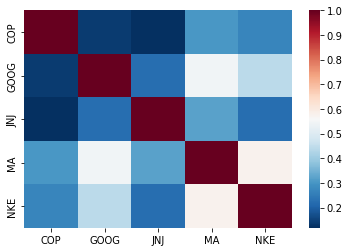

In [4]:
sns.heatmap(cov, cmap="RdBu_r")

### 1.d. Markowitz Portfolio Optimization

## Modern Portfolio Theory (MPT) & Efficient Frontier

For this, we'll use the concept of Modern Portfolio Theory (MPT) and its efficient frontier. Classical Markowitz portfolio optimization aims to determine the portfolio weights that minimize the portfolio's variance subject to a given expected return.

### Classical Markowitz Portfolio Optimization

**Setup:**
- \( R \) is the expected portfolio return.
- \( w \) is the weight vector for the securities.
- \( Sigma \) is the covariance matrix of the returns which is derived from \( cov \) above.

**Objective:**
- Minimize: \( w^T \Sigma w \)
- Subject to: 
  - \( R^T w = \mu \) (Target return)
  - \( \sum w = 1 \)

For the purpose of the demonstration, we'll set the target return \( \mu \) as the average of the annualized returns of the securities in the portfolio.

Optimal Weights:
 {'JNJ': 0.2426969500103096, 'GOOG': 0.09910094085486047, 'NKE': 0.4574210503599623, 'MA': 0.20078105877486765, 'COP': 0.0}


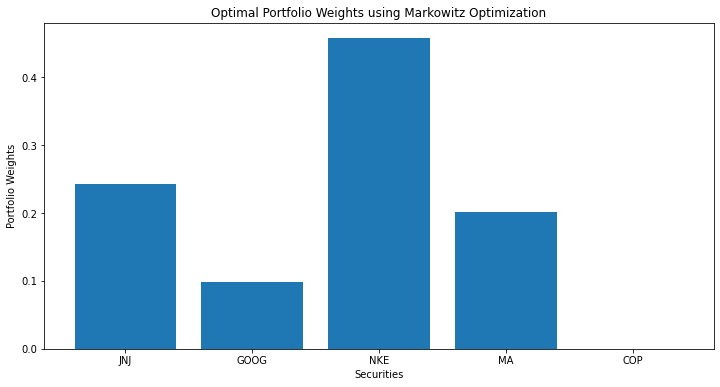

In [5]:
from scipy.optimize import minimize

# Calculate annualized returns and covariance matrix
annualized_returns = df.mean() * 250  # Assuming 250 trading days in a year
annualized_cov = df.cov() * 250

# Objective function
def objective(weights): 
    portfolio_variance = np.dot(weights.T, np.dot(annualized_cov, weights))
    return portfolio_variance

# Constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
               {'type': 'eq', 'fun': lambda weights: np.sum(weights * annualized_returns) - annualized_returns.mean()})

# Bounds: No shorts allowed, so weights range from 0 to 1
bounds = tuple((0, 1) for asset in range(len(annualized_returns)))

# Initialize weights equally
initial_weights = [1./len(annualized_returns) for asset in annualized_returns]

# Run the optimizer
solution = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the weights
optimal_weights = solution.x

# Display the weights
print("Optimal Weights:\n", dict(zip(tickers, optimal_weights)))

# Optionally plot
plt.figure(figsize=(12,6))
plt.bar(tickers, optimal_weights)
plt.ylabel("Portfolio Weights")
plt.xlabel("Securities")
plt.title("Optimal Portfolio Weights using Markowitz Optimization")
plt.show()


### Interpretation:

#### 'JNJ' (Johnson & Johnson):
- **Portfolio Weight:** 24.27%  
  This suggests that for an optimal risk-return trade-off, about 24.27% of the portfolio should be allocated to JNJ stock.

#### 'GOOG' (Google / Alphabet Inc.):
- **Portfolio Weight:** 9.91%  
  The optimizer suggests allocating about 9.91% of the portfolio to GOOG stock. This might imply that, given the other stocks in the portfolio and the target return, a smaller allocation to GOOG optimizes the risk-return profile.

#### 'NKE' (Nike):
- **Portfolio Weight:** 45.74%  
  Nike appears to be the major player in the optimal portfolio with a whopping allocation of 45.74%. This might suggest that NKE offers a favorable risk-return profile given the constraints and target return.

#### 'MA' (Mastercard):
- **Portfolio Weight:** 20.08%  
  About 20.08% of the portfolio should be allocated to Mastercard. This allocation suggests that Mastercard has a significant role in optimizing the risk-return profile of the portfolio in conjunction with the other selected stocks.

#### 'COP' (ConocoPhillips):
- **Portfolio Weight:** 0%  
  The optimizer suggests not allocating any portfolio weight to COP. This might imply that, in the context of achieving the target return with minimal risk, the inclusion of COP does not contribute positively. In other words, given the other stocks in the portfolio, having COP in the mix might not be optimal for the desired risk-return trade-off.

### Conclusion:
The Markowitz Portfolio Optimization has provided an optimal weight allocation that minimizes risk (portfolio variance) for a given target return. The weights show the importance of diversification, as they distribute the investments across various assets. This helps in mitigating unsystematic risks.

It's also essential to remember that portfolio optimization is based on historical data. Thus, while it provides insights, it's crucial to consider other factors, such as current market conditions, future growth potential, external economic factors, etc., when making investment decisions.


### 2.a. Black-Litterman Model

Applying the BL portfolio optimization. Compare the original portfolio allocation with the BL results. The comparison should include differences
in weights and performance.

In [146]:
# Historical returns
returns = df.dropna()

# Covariance matrix
cov_matrix = returns.cov()

# Original weights
original_weights = np.array([0.2427, 0.0991, 0.4574, 0.2008, 0.0])

# Risk-free rate
rf_rate = 0.02

In [147]:
returns.mean()

COP     0.001253
GOOG    0.000819
JNJ     0.000179
MA      0.000589
NKE     0.000087
dtype: float64

Define the Black-Litterman Model Parameters:

In [148]:
returns.head()

COP      GOOG       JNJ        MA       NKE
Date                                                        
2022-08-02 -0.004101  0.003637 -0.005693 -0.004365 -0.022135
2022-08-03 -0.035793  0.024849  0.009658  0.014670  0.022457
2022-08-04 -0.015769  0.000758 -0.016038  0.005478  0.001750
2022-08-05  0.033044 -0.005468 -0.003958  0.004044 -0.005328
2022-08-08  0.008401 -0.000677 -0.005318 -0.014965  0.001142

In [149]:

df_original_weights = pd.DataFrame(original_weights,
                                    index=['COP','GOOG','JNJ','MA','NKE'],
                                    columns=['weights'])
df_original_weights

weights
COP    0.2427
GOOG   0.0991
JNJ    0.4574
MA     0.2008
NKE    0.0000

In [150]:
# Calculate the global market mean return, variance and the risk aversion parameter
excess_returns = returns.subtract(rf_rate, axis=0)
cov = excess_returns.cov()
global_return = excess_returns.mean().multiply(df_original_weights['weights'].values).sum()
market_var = np.matmul(df_original_weights.values.reshape(len(df_original_weights)).T,
                                       np.matmul(cov.values, df_original_weights.values.reshape(len(df_original_weights))))
print(f'The global market mean return is {global_return:.4f} and the variance is {market_var:.6}')
risk_aversion = global_return / market_var
print(f'The risk aversion parameter is {risk_aversion:.2f}')

The global market mean return is -0.0194 and the variance is 0.000106547
The risk aversion parameter is -182.22


In [151]:
risk_aversion

-182.21519901367193

In [152]:
cov

COP      GOOG       JNJ        MA       NKE
COP   0.000512  0.000070  0.000028  0.000100  0.000134
GOOG  0.000070  0.000503  0.000052  0.000178  0.000219
JNJ   0.000028  0.000052  0.000109  0.000049  0.000052
MA    0.000100  0.000178  0.000049  0.000213  0.000186
NKE   0.000134  0.000219  0.000052  0.000186  0.000489

In [153]:
df_original_weights.shape

(5, 1)

In [154]:
cov.shape

(5, 5)

In [155]:
np.dot(cov,df_original_weights)

array([[1.63977491e-04],
       [1.26511936e-04],
       [7.16110243e-05],
       [1.06860663e-04],
       [1.15190543e-04]])

In [164]:
# Implied Equilibrium Returns Vector
def implied_rets(risk_aversion, sigma, w):
    
    implied_rets = risk_aversion * np.dot(cov,df_original_weights).squeeze()
    
    return implied_rets

implied_equilibrium_returns = implied_rets(risk_aversion, cov, df_original_weights)

implied_equilibrium_returns = pd.DataFrame(implied_equilibrium_returns,
                                    index=['COP','GOOG','JNJ','MA','NKE'],
                                    columns=['implied_equilibrium_returns'])
implied_equilibrium_returns

implied_equilibrium_returns
COP                     -0.029879
GOOG                    -0.023052
JNJ                     -0.013049
MA                      -0.019472
NKE                     -0.020989

Let K be the number of views and N be the number of assets. As per Black-Litterman formula:

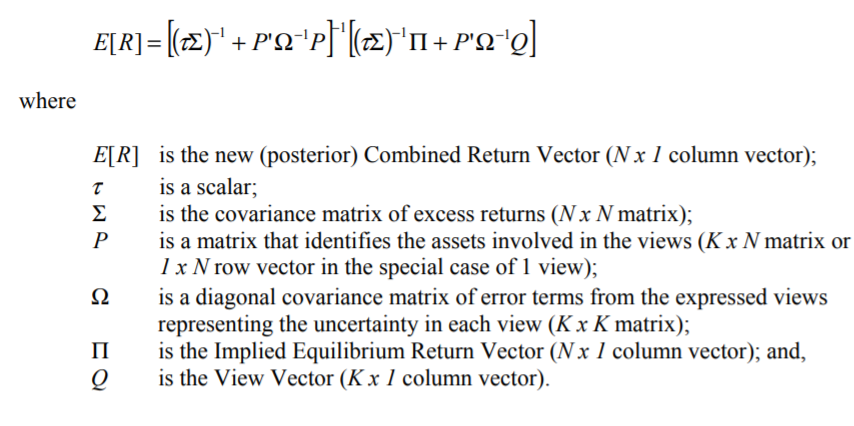

### Define the views and the uncertainty of the views

View 1: Google has an absolute excess return of -3% (as opposed to the -2.3% equilibrium based value) - Absolute View

View 2: Johnson & Johnson outperforms Nike and Google by 0.5% ((as opposed to the ~1% equilibrium based value) - Relative View

View 3: Mastercard will have an absolute excess return of -1.0% (as opposed to the -2% equilibrium based value)- Absolute View

In [165]:
# Matrix Q - 3 views
Q = np.array([-0.03, 0.005, -0.01])

In [166]:
# Matrix P - we have 3 views and 5 assets, so P matrix is 3*5
P = [[0, 1, 0, 0, 0],
    [0, -.05, .05, -.05, 0],
    [0, 0, 0, 1, 0]]

In [167]:
P = np.asarray([[0, 1, 0, 0, 0],
    [0, -.05, .05, -.05, 0],
    [0, 0, 0, 1, 0]])

In [168]:
view1_var = np.matmul(P[0].reshape(len(P[0])),np.matmul(cov.values, P[0].reshape(len(P[0])).T))
view2_var = np.matmul(P[1].reshape(len(P[1])),np.matmul(cov.values, P[1].reshape(len(P[1])).T))
view3_var = np.matmul(P[2].reshape(len(P[2])),np.matmul(cov.values, P[2].reshape(len(P[2])).T))
print(f'The Variance of View 1 Portfolio is {view1_var}, and the standard deviation is {np.sqrt(view1_var):.3f}\n',\
      f'The Variance of View 2 Portfolio is {view2_var}, and the standard deviation is {np.sqrt(view2_var):.3f}\n',\
      f'The Variance of View 3 Portfolio is {view3_var}, and the standard deviation is {np.sqrt(view3_var):.3f}')

The Variance of View 1 Portfolio is 0.0005032972651408252, and the standard deviation is 0.022
 The Variance of View 2 Portfolio is 2.4492591561576863e-06, and the standard deviation is 0.002
 The Variance of View 3 Portfolio is 0.0002126168449956751, and the standard deviation is 0.015


In [172]:
## Setting the error cov matrix
def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * cov).dot(P.T)))
    return matrix
tau = 0.025
omega = error_cov_matrix(cov, tau, P)

In [177]:
## Calculating the View-Based Return Vector
sigma_scaled = cov * tau
BL_return_vector = implied_equilibrium_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T) + omega).dot(Q - P.dot(implied_equilibrium_returns)))

In [178]:
BL_return_vector

implied_equilibrium_returns   0   1   2
COP                           NaN NaN NaN NaN
GOOG                          NaN NaN NaN NaN
JNJ                           NaN NaN NaN NaN
MA                            NaN NaN NaN NaN
NKE                           NaN NaN NaN NaN

### 3.a. Back-testing using the Kelly criterion for each security in the portfolio to size the allocation to that security.

In [6]:
window = 10
days = 250
r_f = 0.02

In [7]:
ticker = "JNJ"

In [8]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Kelly optimal $f^*$ prediction capacity for JNJ')

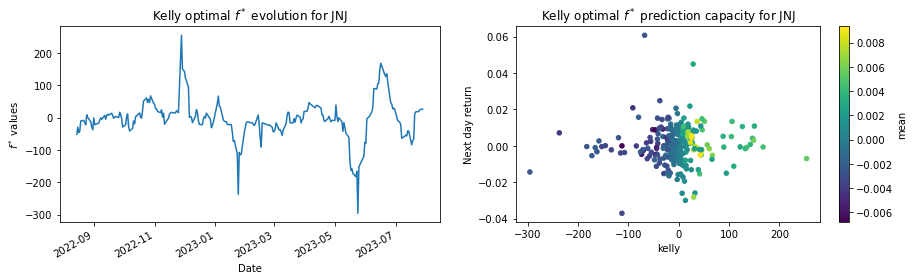

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [10]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

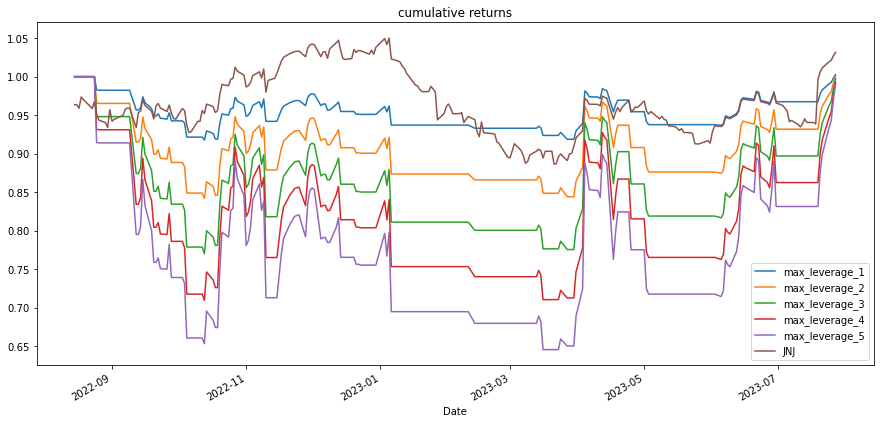

In [11]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [12]:
ticker = "GOOG"

In [13]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Kelly optimal $f^*$ prediction capacity for GOOG')

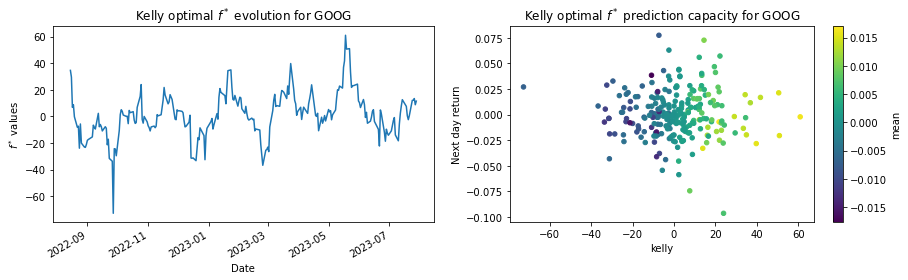

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [15]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

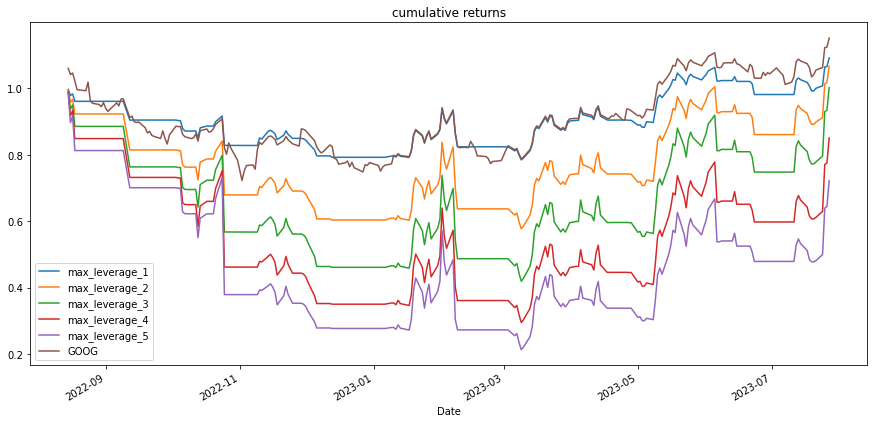

In [16]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [17]:
ticker = "NKE"

In [18]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Kelly optimal $f^*$ prediction capacity for NKE')

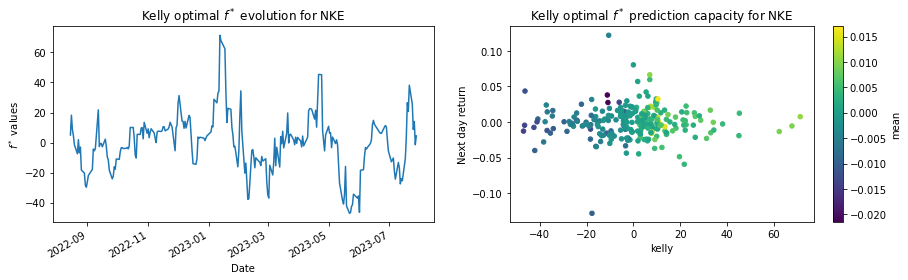

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [20]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

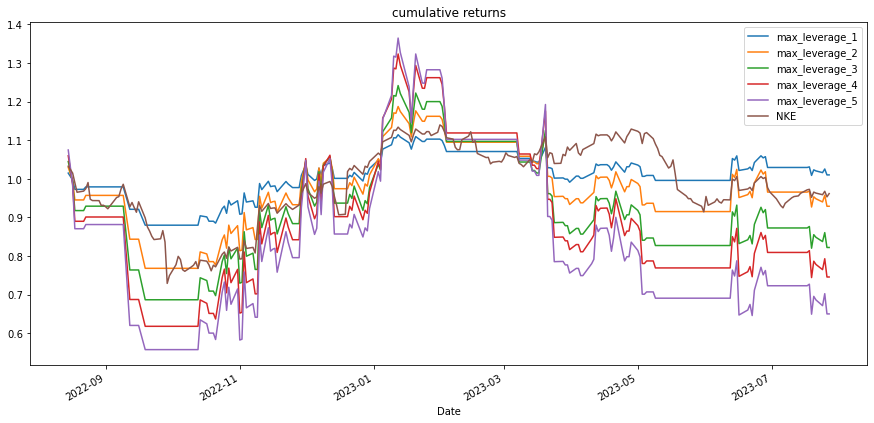

In [21]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [22]:
ticker = "MA"

In [23]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Kelly optimal $f^*$ prediction capacity for MA')

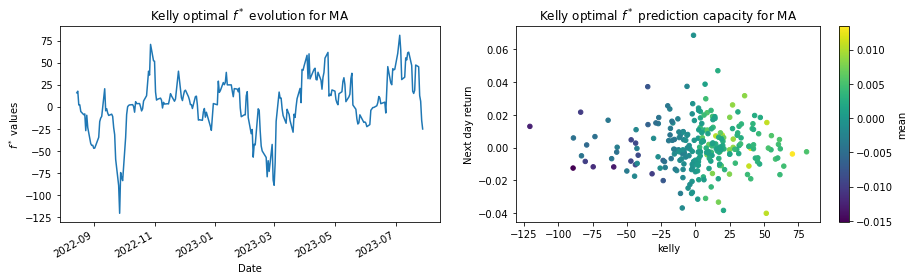

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [25]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

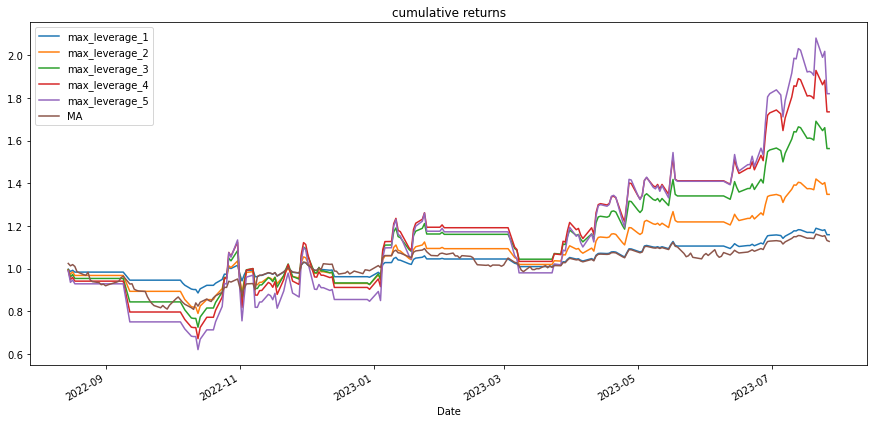

In [26]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [27]:
ticker = "COP"

In [28]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Kelly optimal $f^*$ prediction capacity for COP')

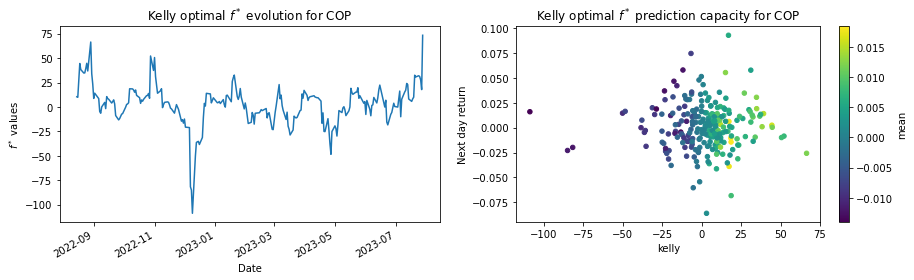

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [30]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

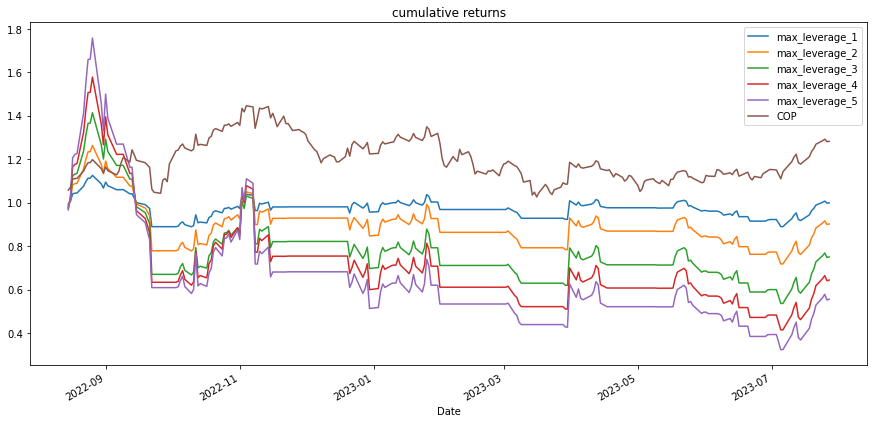

In [31]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

### 3.b. Historical backtests to see how the combined portfolio performs.

In [32]:
# f* values for correlated securities
opt_correlated_kelly = get_kelly(df, 
                                 window=window, 
                                 days=days, 
                                 r=r_f, 
                                 correlation=True)

# f* values for uncorrelated securities
opt_uncorrelated_kelly = get_kelly(df, 
                                   window=window, 
                                   days=days, 
                                   r=r_f, 
                                   correlation=False)
# No short
opt_correlated_kelly[opt_correlated_kelly < 0] = 0
opt_uncorrelated_kelly[opt_uncorrelated_kelly < 0] = 0

# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly.index[0]
shift_returns = df.shift(-1)
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly, shift_returns, leverages)

In [33]:
n_companies = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / n_companies
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

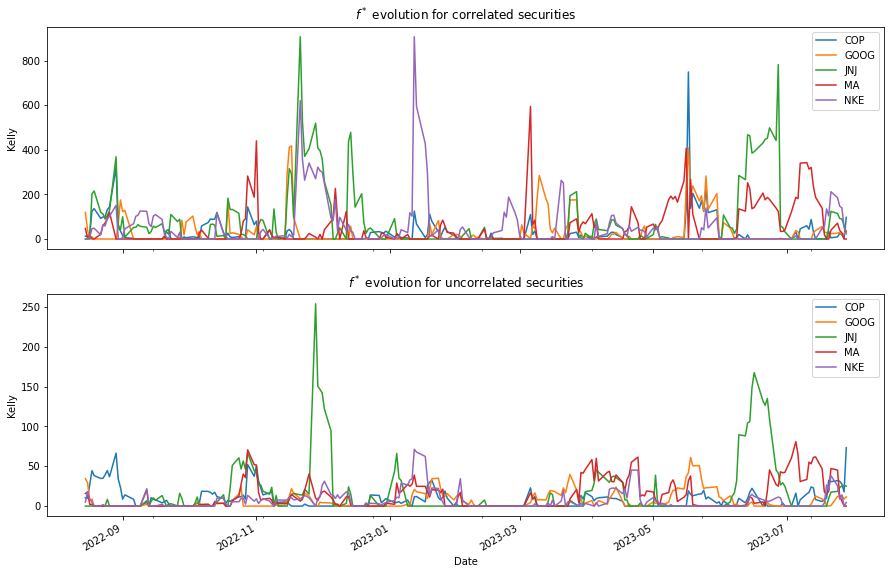

In [34]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

opt_correlated_kelly.plot(ax=ax[0])
ax[0].set_title('$f^*$ evolution for correlated securities');
ax[0].set_ylabel('Kelly');
# ax[0].legend([]);

opt_uncorrelated_kelly.plot(ax=ax[1])
ax[1].set_title('$f^*$ evolution for uncorrelated securities');
ax[1].set_ylabel('Kelly');
# ax[1].legend([]);

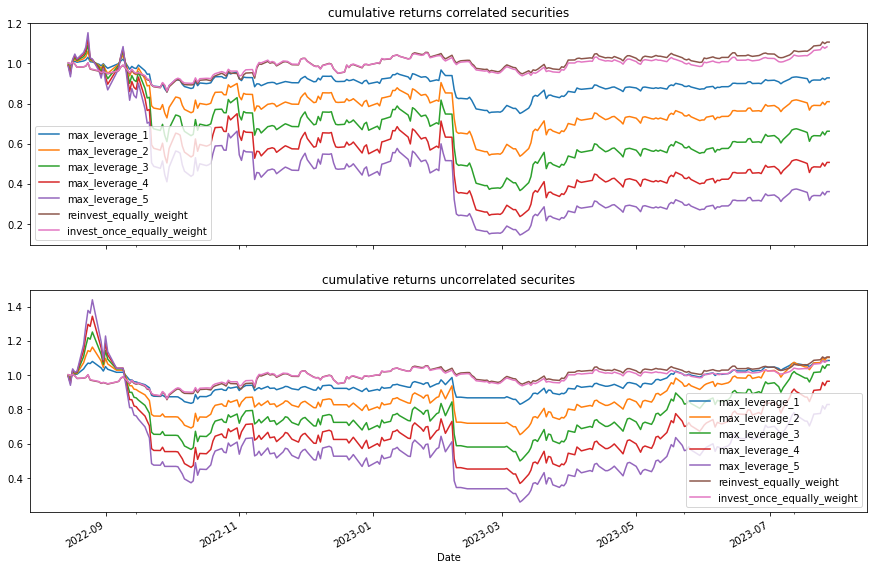

In [35]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('cumulative returns correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('cumulative returns uncorrelated securites');

### 3.c. Please refer to the report for writeup 

### 4.a.1 Applying Leverage Constraints Less than Kelly - Back-testing using the Half-Kelly criterion for each security in the portfolio to size the allocation to that security.

In [36]:
window = 10
days = 250
r_f = 0.02

In [37]:
ticker = "JNJ"

In [38]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 0.5*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Half-Kelly optimal $f^*$ prediction capacity for JNJ')

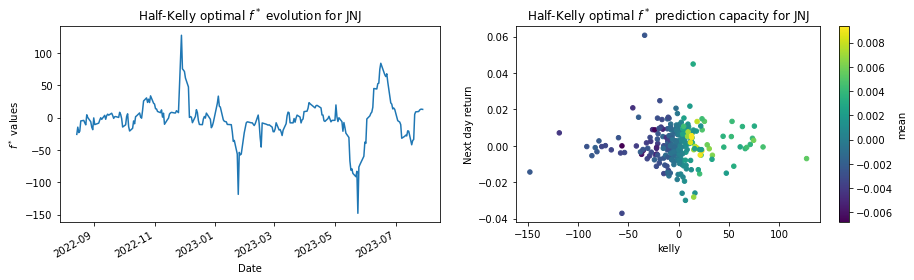

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Half-Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Half-Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [40]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

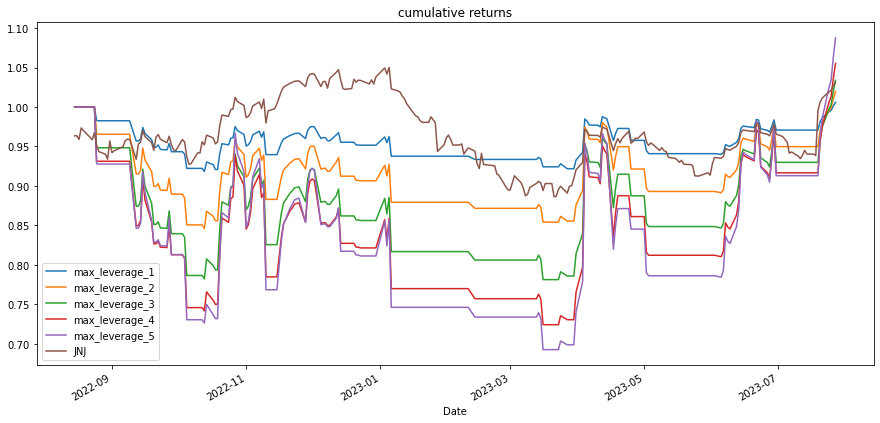

In [41]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [42]:
ticker = "GOOG"

In [43]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 0.5*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Half-Kelly optimal $f^*$ prediction capacity for GOOG')

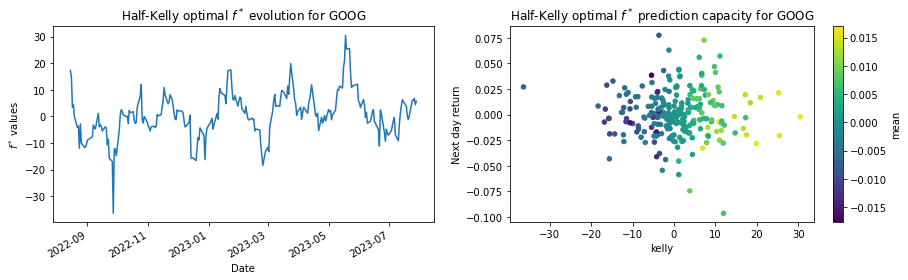

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Half-Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Half-Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [45]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

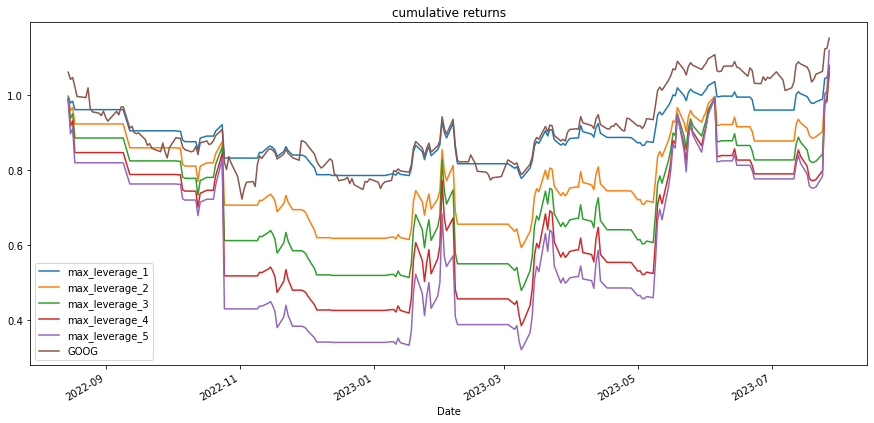

In [46]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [47]:
ticker = "NKE"

In [48]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 0.5*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Half-Kelly optimal $f^*$ prediction capacity for NKE')

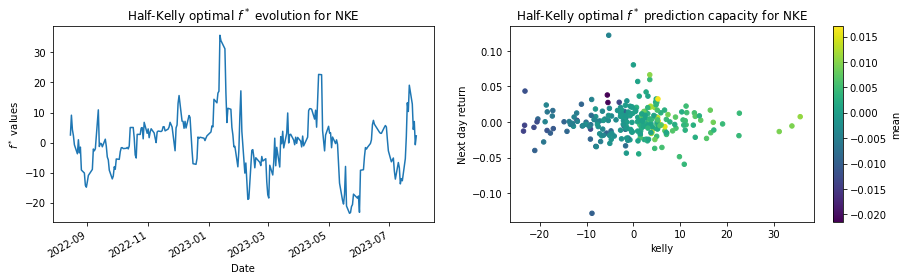

In [49]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Half-Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Half-Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [50]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

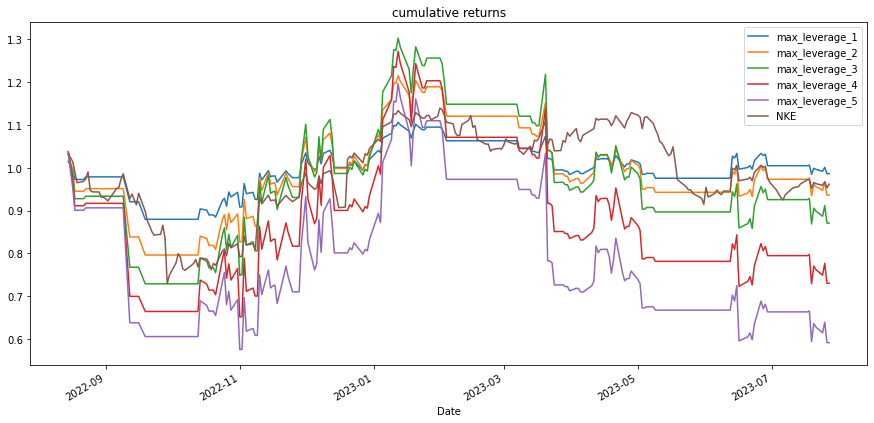

In [51]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [52]:
ticker = "MA"

In [53]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 0.5*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Half-Kelly optimal $f^*$ prediction capacity for MA')

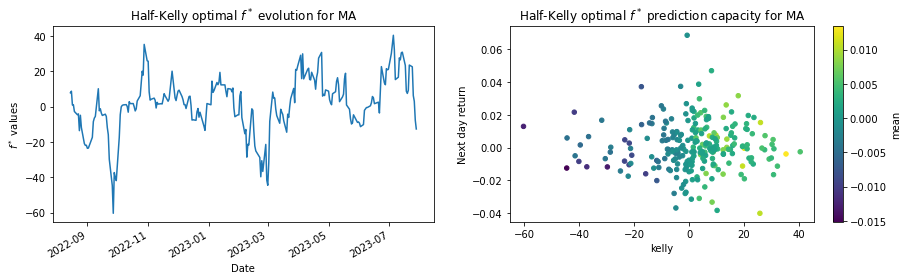

In [54]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Half-Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Half-Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [55]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

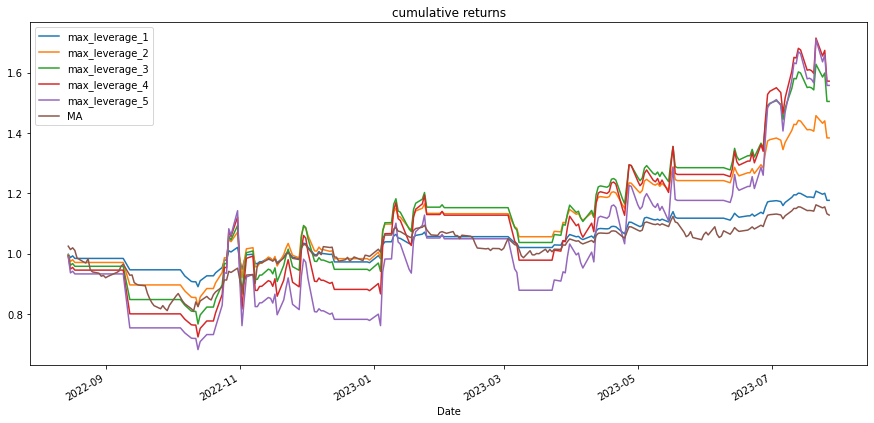

In [56]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [57]:
ticker = "COP"

In [58]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 0.5*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Half-Kelly optimal $f^*$ prediction capacity for COP')

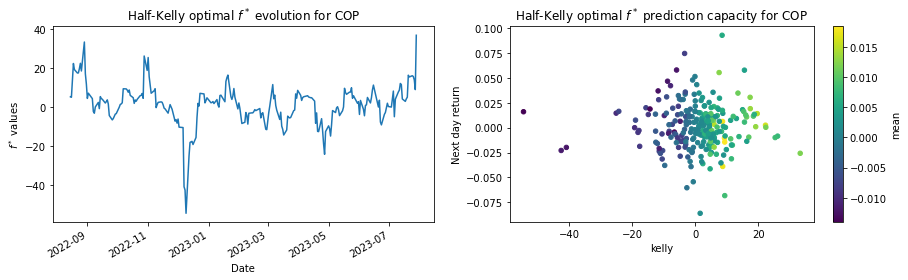

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Half-Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Half-Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [60]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

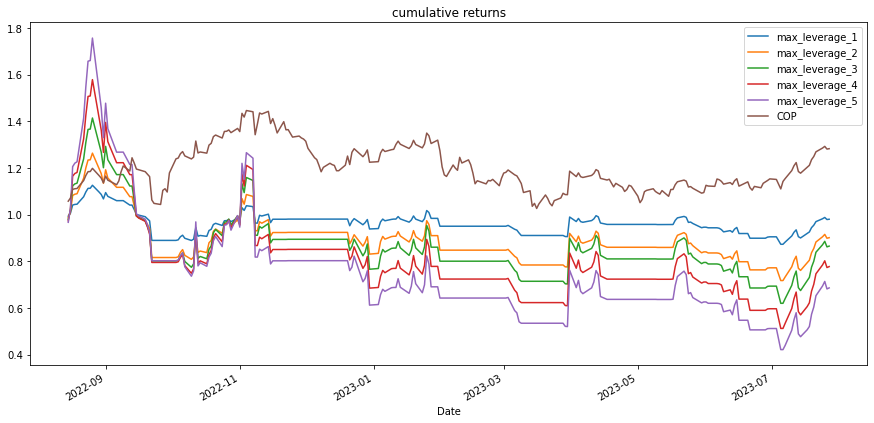

In [61]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

### 4.a.2 Applying Leverage Constraints less than Kelly - Half-Kelly - Historical backtests to see how the combined portfolio performs.

In [62]:
# f* values for correlated securities
opt_correlated_kelly = 0.5*get_kelly(df, 
                                 window=window, 
                                 days=days, 
                                 r=r_f, 
                                 correlation=True)

# f* values for uncorrelated securities
opt_uncorrelated_kelly = 0.5*get_kelly(df, 
                                   window=window, 
                                   days=days, 
                                   r=r_f, 
                                   correlation=False)
# No short
opt_correlated_kelly[opt_correlated_kelly < 0] = 0
opt_uncorrelated_kelly[opt_uncorrelated_kelly < 0] = 0

# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly.index[0]
shift_returns = df.shift(-1)
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly, shift_returns, leverages)

In [63]:
n_companies = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / n_companies
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

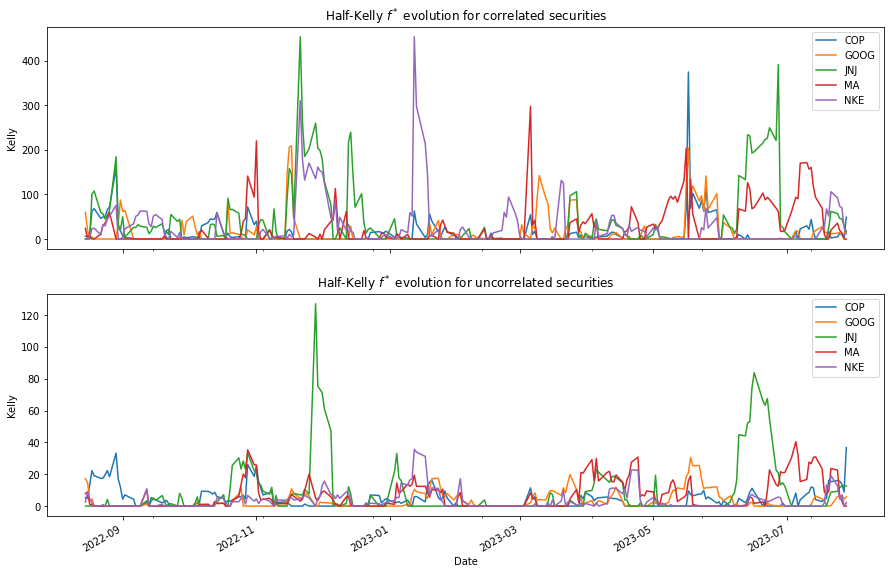

In [64]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

opt_correlated_kelly.plot(ax=ax[0])
ax[0].set_title('Half-Kelly $f^*$ evolution for correlated securities');
ax[0].set_ylabel('Kelly');
# ax[0].legend([]);

opt_uncorrelated_kelly.plot(ax=ax[1])
ax[1].set_title('Half-Kelly $f^*$ evolution for uncorrelated securities');
ax[1].set_ylabel('Kelly');
# ax[1].legend([]);

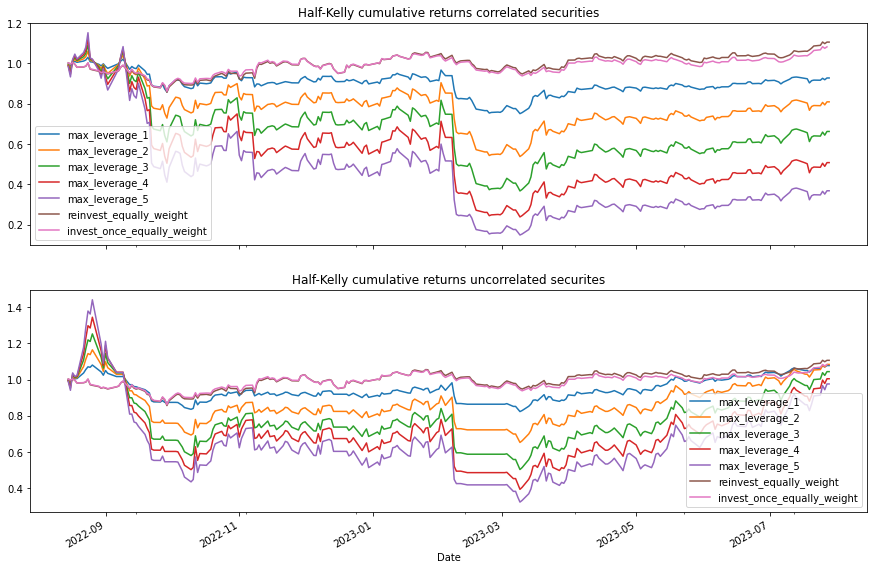

In [65]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('Half-Kelly cumulative returns correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('Half-Kelly cumulative returns uncorrelated securites');

### 4.b.1 Applying Leverage Constraint greater than Kelly - Back-testing using the 2*Kelly criterion for each security in the portfolio to size the allocation to that security.

In [66]:
window = 10
days = 250
r_f = 0.02

In [67]:
ticker = "JNJ"

In [68]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 2*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Double Kelly optimal $f^*$ prediction capacity for JNJ')

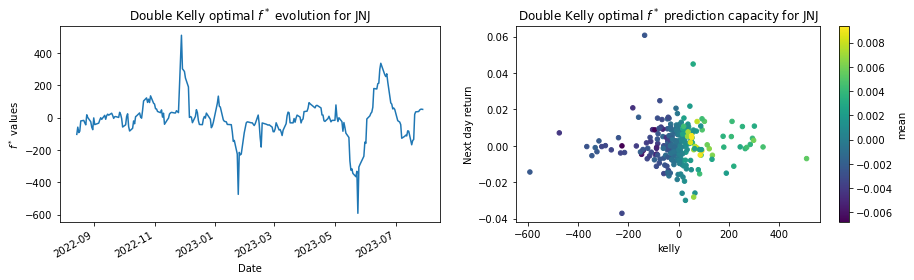

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Double Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Double Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [70]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

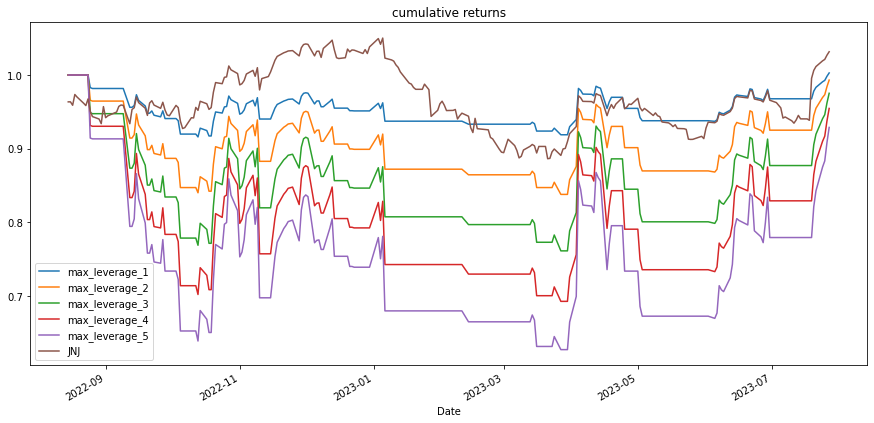

In [71]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [72]:
ticker = "GOOG"

In [73]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 2*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Double Kelly optimal $f^*$ prediction capacity for GOOG')

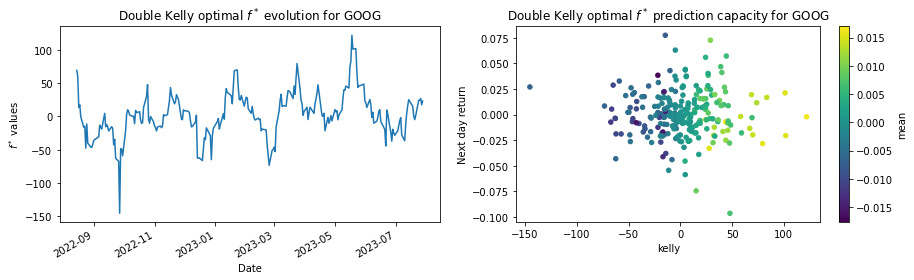

In [74]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Double Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Double Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [75]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

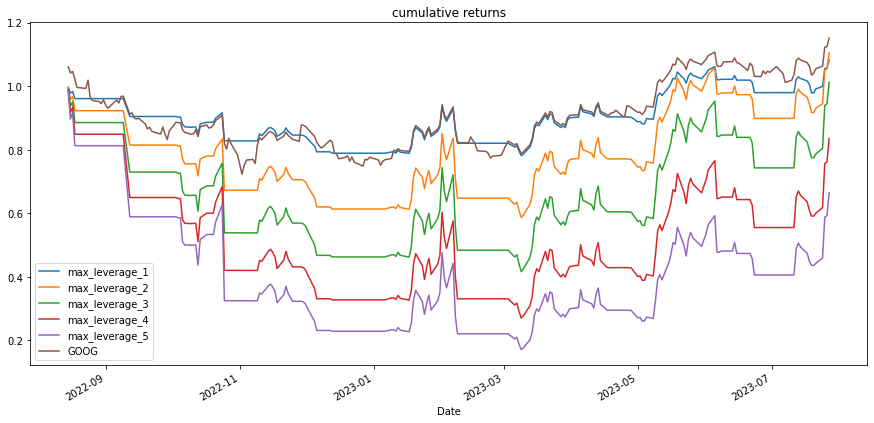

In [76]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [77]:
ticker = "NKE"

In [78]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 2*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Double Kelly optimal $f^*$ prediction capacity for NKE')

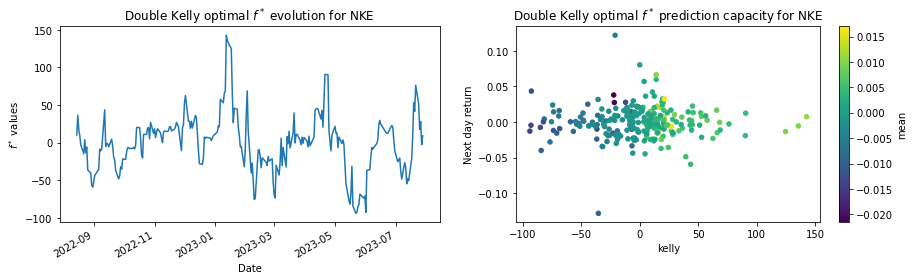

In [79]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Double Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Double Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [80]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

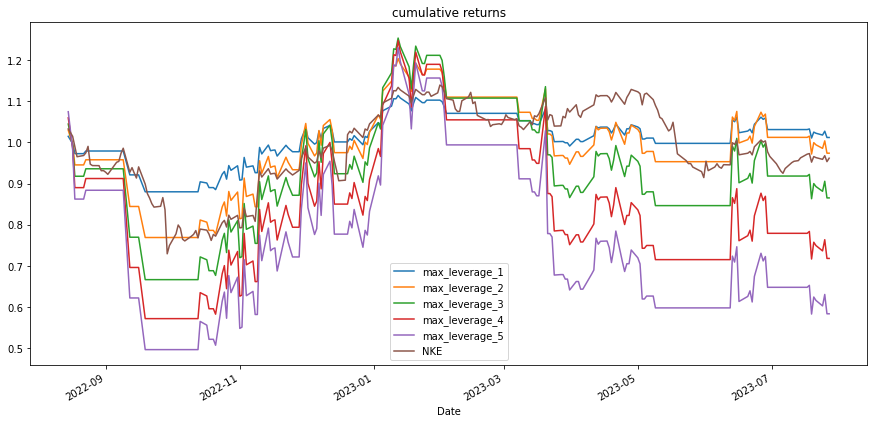

In [81]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [82]:
ticker = "MA"

In [83]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 2*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Double Kelly optimal $f^*$ prediction capacity for MA')

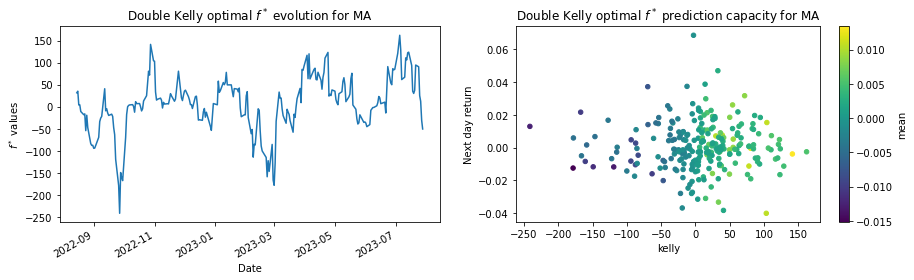

In [84]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Double Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Double Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [85]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

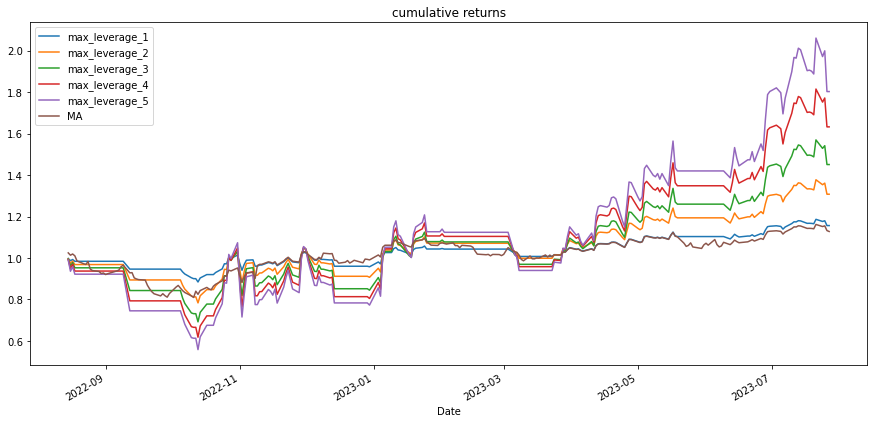

In [86]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

In [87]:
ticker = "COP"

In [88]:
shift_returns = df[ticker].shift(-1)

expanding_kelly = 2*get_kelly(df[ticker], 
                            window=window, 
                            days=days, 
                            r=r_f)

parameters_df = pd.DataFrame()
parameters_df['kelly'] = expanding_kelly
parameters_df['Next day return'] = shift_returns
parameters_df['mean'] = df[ticker].rolling(window).mean() 

Text(0.5, 1.0, 'Double Kelly optimal $f^*$ prediction capacity for COP')

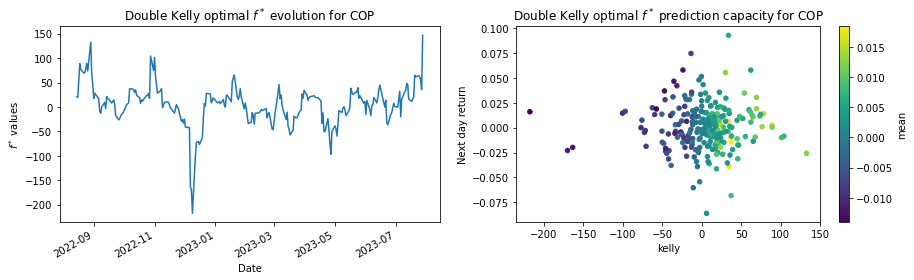

In [89]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

expanding_kelly.plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Double Kelly optimal $f^*$ evolution for ' + ticker);

parameters_df.plot.scatter(
    x='kelly', y='Next day return', c='mean', colormap='viridis', ax=ax[1],
)
ax[1].set_title('Double Kelly optimal $f^*$ prediction capacity for ' + ticker)

In [90]:
all_returns_df = pd.DataFrame()

# setting the leverages
upper = min(5, int(np.ceil(expanding_kelly.max())))
leverages = range(1, upper+1)

# returns starting in the first day available
first_date = expanding_kelly.index[0]
shift_returns_sp500 = shift_returns[first_date:]

for leverage in leverages:
    filter_kelly = filter_leverage(expanding_kelly, leverage)

    # No short
    filter_kelly[filter_kelly < 0] = 0
    
    name = 'max_leverage_' + str(leverage)    
    all_returns_df[name] = shift_returns * filter_kelly
    
all_returns_df[ticker] = shift_returns

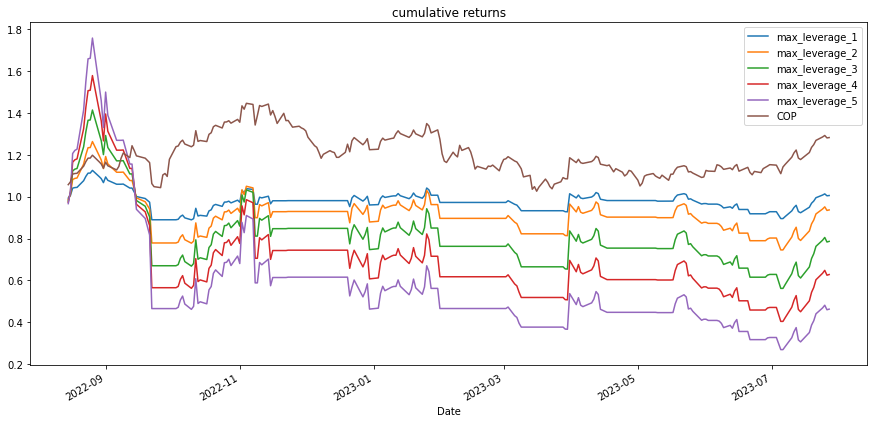

In [91]:
cum_returns = get_cumulative_returns(all_returns_df)

cum_returns.plot(figsize=(15, 7))
plt.title('cumulative returns');

### 4.b.2 Applying Leverage Constraints greater than Kelly - 2*Kelly - Historical backtests to see how the combined portfolio performs.

In [92]:
# f* values for correlated securities
opt_correlated_kelly = 2*get_kelly(df, 
                                 window=window, 
                                 days=days, 
                                 r=r_f, 
                                 correlation=True)

# f* values for uncorrelated securities
opt_uncorrelated_kelly = 2*get_kelly(df, 
                                   window=window, 
                                   days=days, 
                                   r=r_f, 
                                   correlation=False)
# No short
opt_correlated_kelly[opt_correlated_kelly < 0] = 0
opt_uncorrelated_kelly[opt_uncorrelated_kelly < 0] = 0

# set parameters for the backtest
leverages = range(1, 6)
start_date = opt_correlated_kelly.index[0]
shift_returns = df.shift(-1)
shift_returns = shift_returns[start_date:]

# make the backtest
total_returns_corr = backtest(opt_correlated_kelly, shift_returns, leverages)
total_returns_uncorr = backtest(opt_uncorrelated_kelly, shift_returns, leverages)

In [93]:
n_companies = len(shift_returns.columns)

# invest once and don't touch it again
cum_returns_ew = get_cumulative_returns(shift_returns)
cum_returns_ew = cum_returns_ew / n_companies
invest_once_equally_weight = cum_returns_ew.sum(axis=1)

# reinvest every day
total_returns_corr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies
total_returns_uncorr['reinvest_equally_weight'] = shift_returns.sum(axis=1) / n_companies

# cumulative returns for correlated securities
cum_returns_corr = get_cumulative_returns(total_returns_corr)
cum_returns_corr['invest_once_equally_weight'] = invest_once_equally_weight

# cumulative returns for uncorrelated securities
cum_returns_uncorr = get_cumulative_returns(total_returns_uncorr)
cum_returns_uncorr['invest_once_equally_weight'] = invest_once_equally_weight

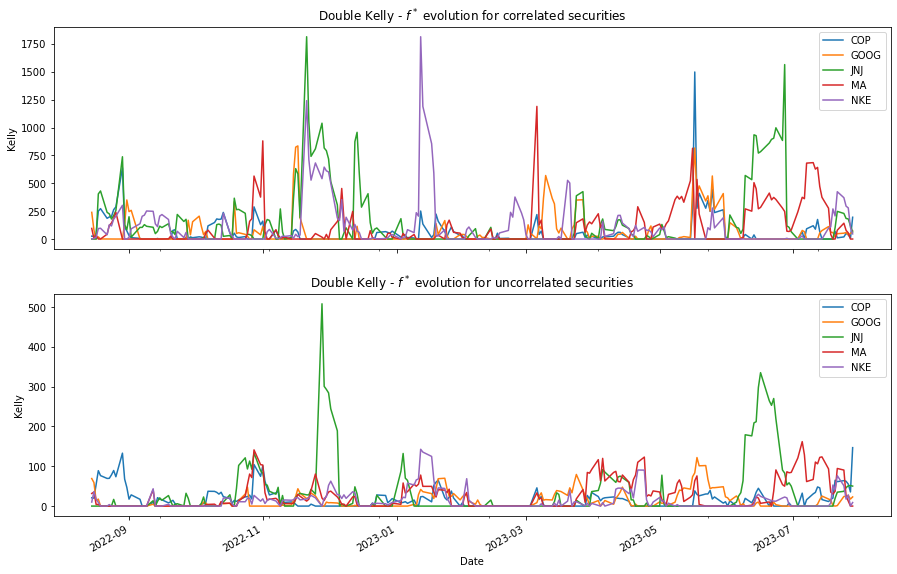

In [94]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

opt_correlated_kelly.plot(ax=ax[0])
ax[0].set_title('Double Kelly - $f^*$ evolution for correlated securities');
ax[0].set_ylabel('Kelly');
# ax[0].legend([]);

opt_uncorrelated_kelly.plot(ax=ax[1])
ax[1].set_title('Double Kelly - $f^*$ evolution for uncorrelated securities');
ax[1].set_ylabel('Kelly');
# ax[1].legend([]);

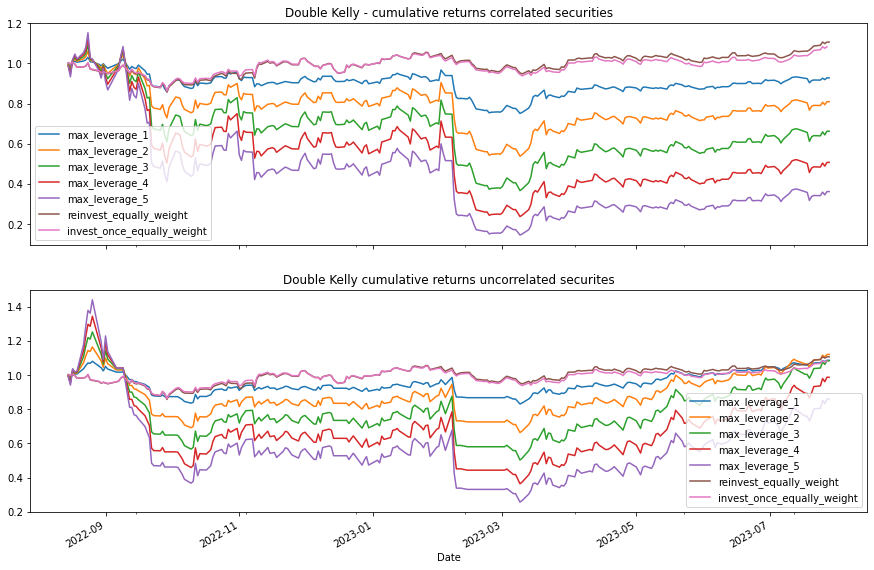

In [95]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

cum_returns_corr.plot(ax=ax[0])
ax[0].set_title('Double Kelly - cumulative returns correlated securities');

cum_returns_uncorr.plot(ax=ax[1])
ax[1].set_title('Double Kelly cumulative returns uncorrelated securites');